In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import joblib as jl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

root = 'dl'

Using TensorFlow backend.


# Load raw data

In [2]:
labels = pd.read_csv('../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
labels.head()

,CLASS
PIN,
568483,1
923748,0
2035328,0
2239386,1
2244533,1


In [3]:
data = jl.load(open('../../tmp/item_days_raw_data_.pkl', 'rb')).loc[labels.index, 'seq']
# data = pd.read_csv('../../tmp/raw_sequences.csv', header=0, index_col=0).loc[labels.index, 'seq']
df = pd.DataFrame(columns=['Seq', 'Class'], index=data.index)
df.loc[:, 'Seq'] = data
df.loc[:, 'Class'] = labels['CLASS']
df.head()

,Seq,Class
PIN,,
568483,10990 0 23 16 725 0 10990 0 10990 0 10990 0 10...,1
923748,66653 0 65070 0 66515 5 10962 1 105 1 56807 42...,0
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0
2239386,10991 0 23 105 73928 0 66560 0 66515 0 66551 0...,1
2244533,10990 0 23 74 23 0 10990 1 73928 0 66500 0 665...,1


# Separate MBS items and timepoints

In [4]:
for idx in df.index:
    _tmp = df.loc[idx, 'Seq'].split(' ')
    df.loc[idx, 'mbs_seq'] = ' '.join(_tmp[::2])
    df.loc[idx, 'times_seq'] = ' '.join(_tmp[1::2])

In [5]:
df.head()

,Seq,Class,mbs_seq,times_seq
PIN,,,,
568483,10990 0 23 16 725 0 10990 0 10990 0 10990 0 10...,1,10990 23 725 10990 10990 10990 10993 23 85311 ...,0 16 0 0 0 0 0 15 0 0 13 0 0 0 22 0 0 0 0 0 0 ...
923748,66653 0 65070 0 66515 5 10962 1 105 1 56807 42...,0,66653 65070 66515 10962 105 56807 10990 23 109...,0 0 5 1 1 42 0 26 35 0 0 0 9 0 0 0 5 0 0 0 21 ...
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0,66536 74995 66512 66551 66608 66716 66560 7392...,0 0 0 0 0 0 0 9 1 10 9 138 1 3 31 24 63 0 0 0 ...
2239386,10991 0 23 105 73928 0 66560 0 66515 0 66551 0...,1,10991 23 73928 66560 66515 66551 66536 2517 10...,0 105 0 0 0 0 4 2 27 1 1 7 0 18 132 0 0 0 1 0 ...
2244533,10990 0 23 74 23 0 10990 1 73928 0 66500 0 665...,1,10990 23 23 10990 73928 66500 66560 66551 23 1...,0 74 0 1 0 0 0 2 0 87 0 1 0 0 0 0 0 2 0 6 0 8 ...


# Seq2Tokens

In [6]:
# Define tokenizer object
tokenizer = Tokenizer(char_level=False, lower=False, split=' ')

# Fit on corpus and extract tokenized sequences
tokenizer.fit_on_texts(df['mbs_seq'])
n_feat = len(tokenizer.word_index.keys())
print(n_feat)
seq = tokenizer.texts_to_sequences(df['mbs_seq'])

# Pad tokenized sequences
lengths = [len(x) for x in seq]
maxlen = int(np.percentile(lengths, 95))
p_seq = pad_sequences(seq, maxlen=maxlen)
print(p_seq.shape)

2773
(11744, 445)


# Training - Validation - Test split

In [7]:
# Full dataset
y = df['Class'].ravel()
X = p_seq

# Learn / Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
learn_idx, test_idx = next(sss.split(X, y))

X_learn, y_learn = X[learn_idx, :], y[learn_idx]
X_test, y_test = X[test_idx, :], y[test_idx]

print('{} learn / {} test'.format(len(y_learn), len(y_test)))

# Training / Validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
train_idx, valid_idx = next(sss.split(X_learn, y_learn))

X_train, y_train = X_learn[train_idx, :], y_learn[train_idx]
X_valid, y_valid = X_learn[valid_idx, :], y_learn[valid_idx]

print('{} training / {} validation'.format(len(y_train), len(y_valid)))

5872 learn / 5872 test
5284 training / 588 validation


# Init embedding matrix

In [8]:
D = 100
embedding = pd.read_csv('../../tmp/embedding.{}d.csv'.format(D), header=0, index_col=0)
embedding_matrix = embedding.values

# Model \#1: Embedding + Dense (overfitting like crazy)

In [46]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.05)))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

TypeError: 'int' object is not iterable

In [10]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [11]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/500
5284/5284 [==============================] - 1s 121us/step - loss: 4.8149 - acc: 0.4941 - val_loss: 1.2783 - val_acc: 0.5000
Epoch 2/500
5284/5284 [==============================] - 0s 57us/step - loss: 1.8335 - acc: 0.5019 - val_loss: 2.0491 - val_acc: 0.5000
Epoch 3/500
5284/5284 [==============================] - 0s 56us/step - loss: 1.5501 - acc: 0.5061 - val_loss: 1.3161 - val_acc: 0.5000
Epoch 4/500
5284/5284 [==============================] - 0s 60us/step - loss: 1.3852 - acc: 0.4939 - val_loss: 1.3146 - val_acc: 0.5000
Epoch 5/500
5284/5284 [==============================] - 0s 59us/step - loss: 1.2003 - acc: 0.4945 - val_loss: 1.0733 - val_acc: 0.5034
Epoch 6/500
5284/5284 [==============================] - 0s 63us/step - loss: 1.0801 - acc: 0.5049 - val_loss: 0.8522 - val_acc: 0.5476
Epoch 7/500
5284/5284 [==============================] - 0s 63us/step - loss: 0.9771 - acc: 0.5174 - val_loss: 0.7399 - val_acc: 0.6054


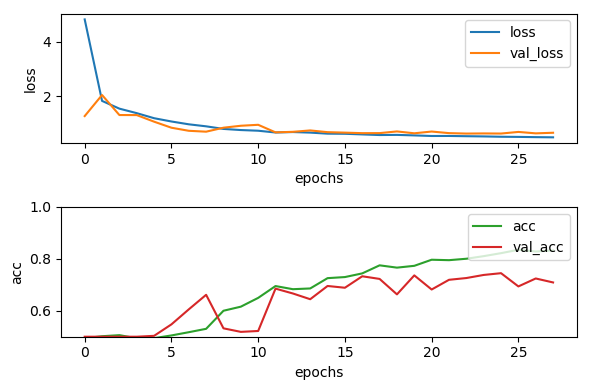

In [12]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_dense.png')

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 0s 81us/step
test_loss: 0.6760 - test_acc: 0.7141


In [14]:
# model.save_weights('embedding_dense.h5')

# Model \#3: Embedding + LSTM

In [15]:
from keras.layers import CuDNNLSTM

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 445, 100)          277300    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                17152     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 294,485
Trainable params: 294,485
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [17]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 3s 636us/step - loss: 0.6788 - acc: 0.5679 - val_loss: 0.6444 - val_acc: 0.6412
Epoch 2/100
5284/5284 [==============================] - 2s 458us/step - loss: 0.6327 - acc: 0.6567 - val_loss: 0.6861 - val_acc: 0.5748
Epoch 3/100
5284/5284 [==============================] - 2s 460us/step - loss: 0.5920 - acc: 0.6864 - val_loss: 0.5665 - val_acc: 0.7143
Epoch 4/100
5284/5284 [==============================] - 2s 463us/step - loss: 0.5662 - acc: 0.7069 - val_loss: 0.5567 - val_acc: 0.7211
Epoch 5/100
5284/5284 [==============================] - 2s 465us/step - loss: 0.5417 - acc: 0.7279 - val_loss: 0.6560 - val_acc: 0.6480
Epoch 6/100
5284/5284 [==============================] - 2s 467us/step - loss: 0.5218 - acc: 0.7403 - val_loss: 0.5292 - val_acc: 0.7109
Epoch 7/100
5284/5284 [==============================] - 2s 460us/step - loss: 0.5067 - acc: 0.7508 - val_loss: 0.5237 - val_acc: 0

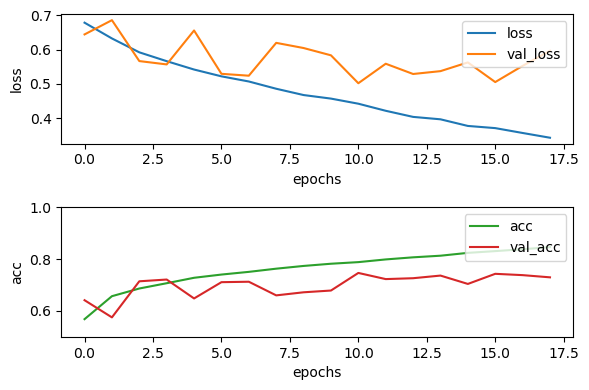

In [18]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_LSTM.png')

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 4s 648us/step
test_loss: 0.5877 - test_acc: 0.7187


In [20]:
model.save_weights(root+'lstm.h5')

# Model \#4: Embedding + Conv1D + LSTM

In [21]:
from keras.layers import Conv1D

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 445, 100)          277300    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 441, 64)           32064     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                12544     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 321,941
Trainable params: 321,941
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [23]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 3s 659us/step - loss: 0.6890 - acc: 0.5413 - val_loss: 0.6666 - val_acc: 0.6378
Epoch 2/300
5284/5284 [==============================] - 3s 553us/step - loss: 0.6463 - acc: 0.6317 - val_loss: 0.6441 - val_acc: 0.6071
Epoch 3/300
5284/5284 [==============================] - 3s 554us/step - loss: 0.6129 - acc: 0.6637 - val_loss: 0.5822 - val_acc: 0.7075
Epoch 4/300
5284/5284 [==============================] - 3s 558us/step - loss: 0.5616 - acc: 0.7144 - val_loss: 0.5447 - val_acc: 0.7330
Epoch 5/300
5284/5284 [==============================] - 3s 563us/step - loss: 0.5304 - acc: 0.7343 - val_loss: 0.5458 - val_acc: 0.7126
Epoch 6/300
5284/5284 [==============================] - 3s 557us/step - loss: 0.5040 - acc: 0.7551 - val_loss: 0.5388 - val_acc: 0.7432
Epoch 7/300
5284/5284 [==============================] - 3s 557us/step - loss: 0.4734 - acc: 0.7763 - val_loss: 0.5213 - val_acc: 0

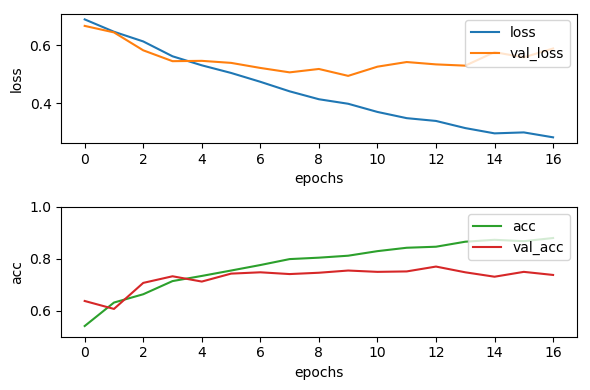

In [24]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_convLSTM.png')

In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 4s 670us/step
test_loss: 0.5653 - test_acc: 0.7587


In [26]:
model.save_weights(root+'conv_lstm.h5')

# Model \#7: Embedding + BiLSTM

In [27]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 445, 100)          277300    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                34304     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 311,669
Trainable params: 311,669
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [29]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)]

history = model.fit(X_train, y_train,
                    epochs=300,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/300
5284/5284 [==============================] - 6s 1ms/step - loss: 0.6859 - acc: 0.5530 - val_loss: 0.7427 - val_acc: 0.5034
Epoch 2/300
5284/5284 [==============================] - 5s 941us/step - loss: 0.6432 - acc: 0.6312 - val_loss: 0.6333 - val_acc: 0.6497
Epoch 3/300
5284/5284 [==============================] - 5s 947us/step - loss: 0.5969 - acc: 0.6832 - val_loss: 0.6449 - val_acc: 0.6224
Epoch 4/300
5284/5284 [==============================] - 5s 948us/step - loss: 0.5733 - acc: 0.7034 - val_loss: 0.5618 - val_acc: 0.7126
Epoch 5/300
5284/5284 [==============================] - 5s 944us/step - loss: 0.5556 - acc: 0.7173 - val_loss: 0.5676 - val_acc: 0.6922
Epoch 6/300
5284/5284 [==============================] - 5s 944us/step - loss: 0.5325 - acc: 0.7360 - val_loss: 0.6171 - val_acc: 0.6854
Epoch 7/300
5284/5284 [==============================] - 5s 939us/step - loss: 0.5195 - acc: 0.7428 - val_loss: 0.5346 - val_acc: 0.7

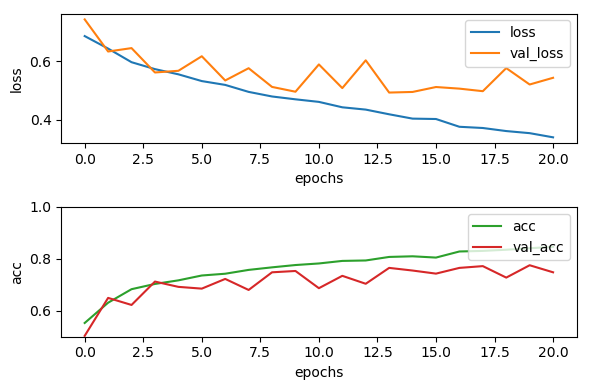

In [30]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'embedding_bilstm.png')

In [31]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 7s 1ms/step
test_loss: 0.5275 - test_acc: 0.7646


In [32]:
# model.save_weights('embedding_bilstm.h5')

# Model \#8: Embedding + Conv1D + BiLSTM

In [36]:
from keras.optimizers import Adam
from keras.layers import MaxPooling1D

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(Conv1D(64, 10, activation='relu'))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 445, 100)          277300    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 436, 64)           64064     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                25088     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 366,517
Trainable params: 366,517
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [38]:
callbacks = [EarlyStopping(monitor='val_loss', patience=7)] 

history = model.fit(X_train, y_train,
                    epochs=500,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/500
5284/5284 [==============================] - 7s 1ms/step - loss: 0.6907 - acc: 0.5369 - val_loss: 0.6610 - val_acc: 0.6378
Epoch 2/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.6473 - acc: 0.6300 - val_loss: 0.6153 - val_acc: 0.6956
Epoch 3/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.6154 - acc: 0.6692 - val_loss: 0.6377 - val_acc: 0.6310
Epoch 4/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.5931 - acc: 0.6908 - val_loss: 0.5688 - val_acc: 0.7160
Epoch 5/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.5715 - acc: 0.7101 - val_loss: 0.5638 - val_acc: 0.7143
Epoch 6/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.5531 - acc: 0.7222 - val_loss: 0.6525 - val_acc: 0.6395
Epoch 7/500
5284/5284 [==============================] - 6s 1ms/step - loss: 0.5390 - acc: 0.7315 - val_loss: 0.5479 - val_acc: 0.7245
Epoch 8/

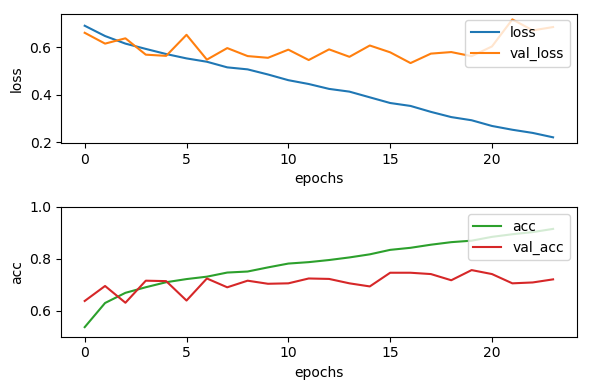

In [39]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_conv_bilstm.png')

In [40]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 8s 1ms/step
test_loss: 0.7044 - test_acc: 0.7156


# Model \#: 10

In [41]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(n_feat, D, input_length=maxlen))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.25, dropout=0.25)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 445, 100)          277300    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 311,413
Trainable params: 311,413
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [43]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)] 

history = model.fit(X_train, y_train,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=128,
                    validation_data=(X_valid, y_valid))

Train on 5284 samples, validate on 588 samples
Epoch 1/100
5284/5284 [==============================] - 81s 15ms/step - loss: 0.6949 - acc: 0.5201 - val_loss: 0.6787 - val_acc: 0.6497
Epoch 2/100
5284/5284 [==============================] - 77s 15ms/step - loss: 0.6765 - acc: 0.5785 - val_loss: 0.6720 - val_acc: 0.5476
Epoch 3/100
5284/5284 [==============================] - 78s 15ms/step - loss: 0.6520 - acc: 0.6281 - val_loss: 0.6191 - val_acc: 0.6820
Epoch 4/100
5284/5284 [==============================] - 73s 14ms/step - loss: 0.6258 - acc: 0.6535 - val_loss: 0.5814 - val_acc: 0.7075
Epoch 5/100
5284/5284 [==============================] - 76s 14ms/step - loss: 0.6053 - acc: 0.6732 - val_loss: 0.5723 - val_acc: 0.7245
Epoch 6/100
5284/5284 [==============================] - 73s 14ms/step - loss: 0.5919 - acc: 0.6896 - val_loss: 0.5783 - val_acc: 0.6990
Epoch 7/100
5284/5284 [==============================] - 69s 13ms/step - loss: 0.5810 - acc: 0.6955 - val_loss: 0.5581 - val_acc: 0

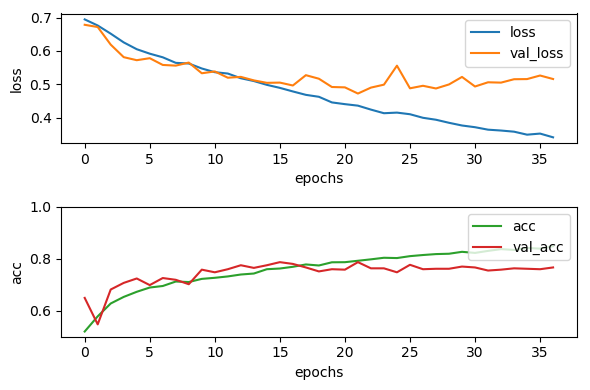

In [44]:
plt.figure(dpi=100)
t = history.epoch

plt.subplot(211)
plt.plot(t, history.history['loss'], label='loss', color='C0')
plt.plot(t, history.history['val_loss'], label='val_loss', color='C1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=1)

plt.subplot(212)
plt.plot(t, history.history['acc'], label='acc', color='C2')
plt.plot(t, history.history['val_acc'], label='val_acc', color='C3')
plt.ylim([0.5, 1])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig(root+'/embedding_dropout_LSTM.png')

In [45]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_loss: {:1.4f} - test_acc: {:1.4f}'.format(test_loss, test_acc))

5872/5872 [==============================] - 64s 11ms/step
test_loss: 0.4874 - test_acc: 0.7803
